# Convolutional Neural Netowork 

---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src="https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/convolutional-neural-networks/cifar-cnn/notebook_ims/cifar_data.png" width=70% height=70%/>

## Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.


In [2]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU ...')
else:
  print('CUDA is available! Training on GPU ...')

CUDA is available! Training on GPU ...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [5]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert datat o normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split: ], indices[:split]

#define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                          sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# specify the images classes/labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


## Visualize a batch of Training data

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# un-normalize and display the data
def imshow(img):
  img = img / 2 + 0.5 #un-normalize the image
  plt.imshow(np.transpose(img, (1, 2, 0))) # convert from Tensor image

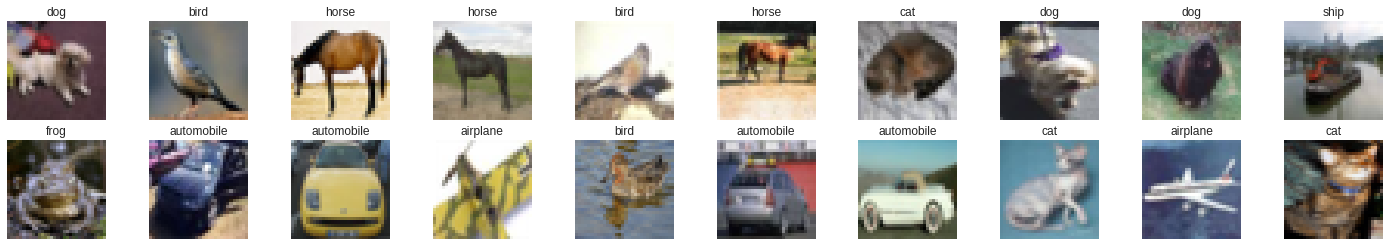

In [9]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images into numpy array

# plot the images in a batch and the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

## View an Image in more detail
____________
Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

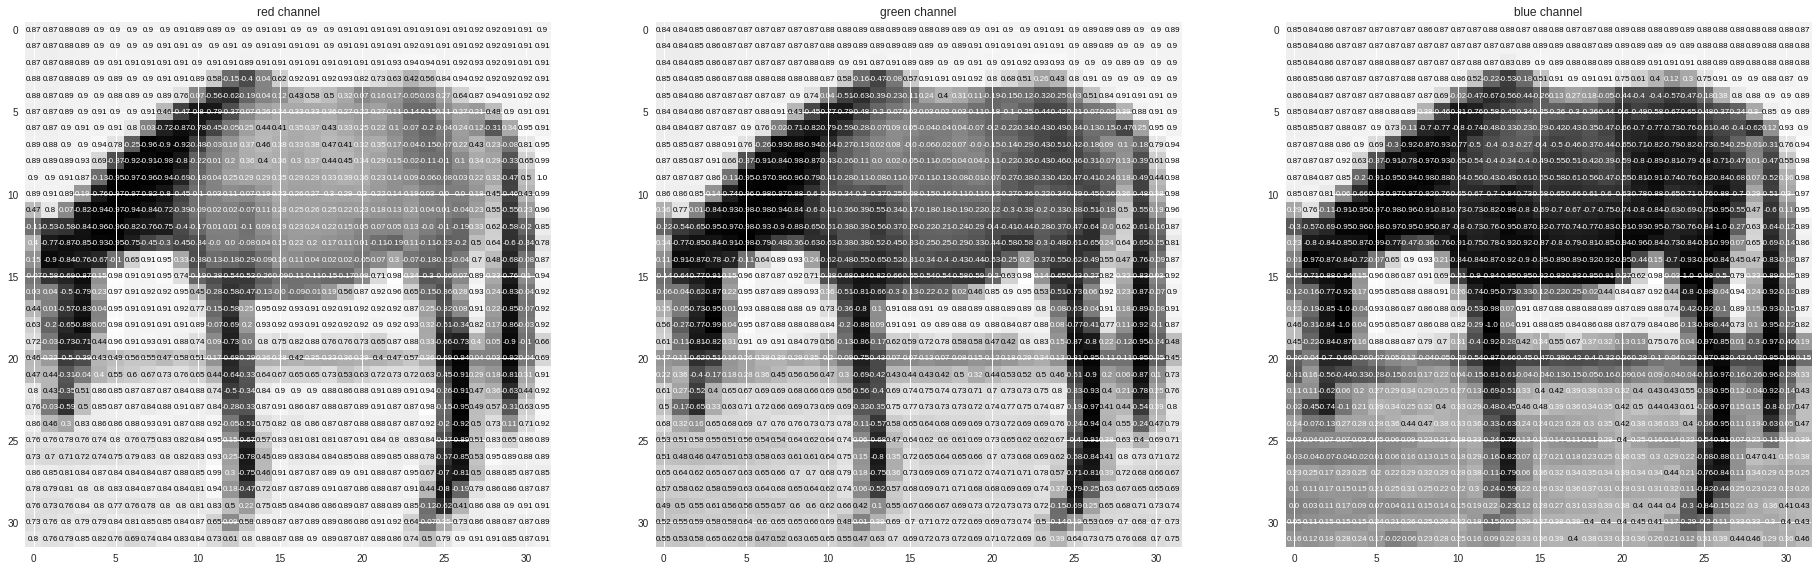

In [17]:
rgb_img = np.squeeze(images[2])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize=(32, 32))
for idx in np.arange(rgb_img.shape[0]):
  ax = fig.add_subplot(1, 3, idx+1)
  img = rgb_img[idx]
  ax.imshow(img, cmap='gray')
  ax.set_title(channels[idx])
  width, height = img.shape
  thresh = img.max() / 2.5
  for x in range(width):
    for y in range(height):
      val = round(img[x][y], 2) if img[x][y] != 0 else 0
      ax.annotate(str(val), xy=(y, x),
                horizontalalignment='center',
                verticalalignment='center', size=8,
                color='white' if img[x][y]<thresh else 'black')
  

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

A network with 2 convolutional layers is shown in the image below and in the code, and you've been given starter code with one convolutional and one maxpooling layer.

<img src="https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/convolutional-neural-networks/cifar-cnn/notebook_ims/2_layer_conv.png" height=50%  width=50%>

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting. 

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architechture
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # convolutional layer
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    # maxpool layer
    self.maxpool = nn.MaxPool2d(2, 2)
    # convolutional layer
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    # fully connected layer
    self.fc1 = nn.Linear(32 * 8 * 8, 256)
    # another fully connected layer
    self.fc2 = nn.Linear(256, 84)
    # final output layer
    self.fc3 = nn.Linear(84, 10)
    
    # dropput layer
    self.dropout = nn.Dropout(p=0.20)
    
  def forward(self, x):
    x = self.maxpool(F.relu(self.conv1(x)))
    x = self.maxpool(F.relu(self.conv2(x)))
    
    # flatten the image so that it can be used for fully connected layer
    x = x.view(-1, 32*8*8)
    # add dropout layer
    x = self.dropout(x)
    # first fully connected hiddenlayer
    x = F.relu(self.fc1(x))
    # add dropout layer
    x = self.dropout(x)
    # second fully connected hidden layer
    x = F.relu(self.fc2(x))
    # output layer
    x = self.fc3(x)
    
    return x
    

In [30]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [0]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
  model.cuda()

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.


In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimzer = optim.SGD(model.parameters(), lr = 0.3)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [33]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf

for epoch in range(1,n_epochs+1):
  # keep track of the validation loss
  train_loss = 0.0
  valid_loss = 0.0
  
  #######################
  ### Train the model ###
  #######################
  model.train()
  for data, target in train_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    # clear the gradients
    optimzer.zero_grad()
    # forward pass
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # backward pass
    loss.backward()
    # single optimization step
    optimzer.step()
    # update the training loss
    train_loss += loss.item()*data.size(0)
    
    
  #########################
  ### Validate the model###
  #########################
  model.eval()
  for data, target in valid_loader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    # forward pass
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update the validation loss
    valid_loss += loss.item()*data.size(0)
    
  # calculate the average losses
  train_loss = train_loss / len(train_loader.dataset)
  valid_loss = valid_loss / len(valid_loader.dataset)
  
  # print training/validation statistics 
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min, valid_loss))
    torch.save(model.state_dict(), 'model_cifar.pt')
    valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.454852 	Validation Loss: 0.365151
Validation loss decreased (inf --> 0.365151).  Saving model ...
Epoch: 2 	Training Loss: 1.268469 	Validation Loss: 0.301536
Validation loss decreased (0.365151 --> 0.301536).  Saving model ...
Epoch: 3 	Training Loss: 1.239358 	Validation Loss: 0.293100
Validation loss decreased (0.301536 --> 0.293100).  Saving model ...
Epoch: 4 	Training Loss: 1.231324 	Validation Loss: 0.285289
Validation loss decreased (0.293100 --> 0.285289).  Saving model ...
Epoch: 5 	Training Loss: 1.228137 	Validation Loss: 0.323062
Epoch: 6 	Training Loss: 1.249004 	Validation Loss: 0.314645
Epoch: 7 	Training Loss: 1.261793 	Validation Loss: 0.304775
Epoch: 8 	Training Loss: 1.279275 	Validation Loss: 0.307853
Epoch: 9 	Training Loss: 1.284981 	Validation Loss: 0.311313
Epoch: 10 	Training Loss: 1.322948 	Validation Loss: 0.323706
Epoch: 11 	Training Loss: 1.328863 	Validation Loss: 0.342767
Epoch: 12 	Training Loss: 1.336111 	Validation Loss: 0.3

## Load the Model with the Lowest Validation Loss

In [0]:
model.load_state_dict(torch.load('model_cifar.pt'))

## Test your trained network

In [37]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over the test data
for data, target in test_loader:
  # move tensord to GPU if CUDA is available
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
  # forward pass
  output = model(data)
  # calculate the batch loss
  loss = criterion(output, target)
  # update the test loss
  test_loss += loss.item()*data.size(0)
  # convert output probabilities into predicted class
  _, pred = torch.max(output, 1)
  # compare predictions to the true label
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(
      correct_tensor.cpu().numpy())
  # calculate test accuracy for each object class
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1
    

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
        classes[i], 100 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 1.412958

Test Accuracy of airplane: 61% (610/1000)
Test Accuracy of automobile: 67% (675/1000)
Test Accuracy of  bird: 28% (280/1000)
Test Accuracy of   cat: 21% (210/1000)
Test Accuracy of  deer: 39% (393/1000)
Test Accuracy of   dog: 65% (653/1000)
Test Accuracy of  frog: 61% (613/1000)
Test Accuracy of horse: 54% (543/1000)
Test Accuracy of  ship: 54% (548/1000)
Test Accuracy of truck: 54% (546/1000)

Test Accuracy (Overall): 50% (5071/10000)


Well it's not a well model. I should have added one more convolutional layer and maxpool that because having only two convolutional layer seems very simple model which can't be able to detect some of complex patterns.

## Question: What are your model's weaknesses and how might they be improved?

In my model cat, deer and bird have the lowest accuracy score.  So basically its kind of clear that it misarably failed at classifying animals whereas it classified vehicles preety well. 

Solution that I'm proposing:

1. We can collect more images of poorly classifying labels so that CNN can learn more about that class.
2. We can add one or two more convolutional layer so that it can extract more complex patterns present in those classes.
3. My learning rate for SGD looks preety large as compared to the problem so we can see after decreasing it. 
4. If we can have a solution in which we can penalize the poorly classified images then it may give us a better result.

## Visualize sample test image

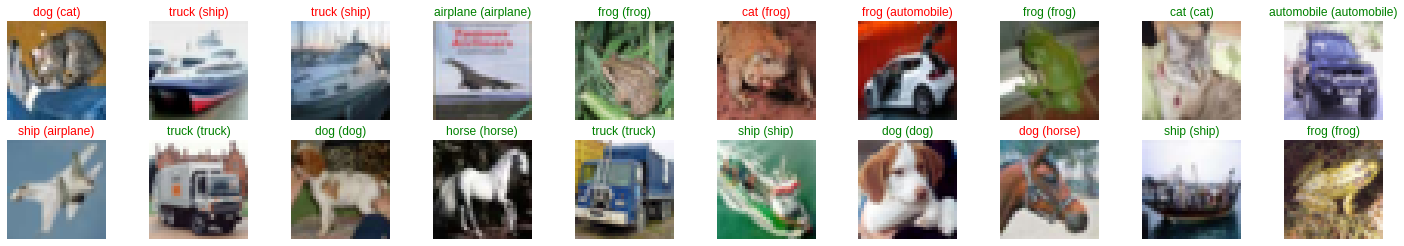

In [38]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
  images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  imshow(images.cpu()[idx])
  ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
               color=("green" if preds[idx]==labels[idx].item() else "red"))



We can see the model is getting confused when it saw images of dog, cat. Either it interpret them as horse or frog in the cases where the whole image is not available or the orientation of the image has been changed.

From this I can remember that capsule network can help us to tackle this type of problem.